In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os

In [3]:
import sqlite3

def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_62_00/icarus_data/database/ChannelMapICARUS.db", table="pmt_placements"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)

    con.close()

    return df

def get_channel_id(db, board, digitizer_channel):
    
    ch = db.loc[(db['digitizer_label']==board) & (db['digitizer_ch_number']==digitizer_channel), ['channel_id']]
    # print(board, ",", digitizer_channel, "-->", ch.values[0][0])

    return ch.values[0][0]

def get_PMT_id(db, channels):
     
    if np.isscalar(channels):
        pmt_id = db[db.channel_id==channels].pmt_id.values[0]
        return pmt_id
    else:
        pmt_ids = [ db[db.channel_id==ch].pmt_id.values[0] for ch in channels ] 
        return pmt_ids

#------------------------------------------------------------------
# help function to parse the board name from the file

def get_board_label(filename):
    
    head, tail = os.path.split(filename)
    buf = tail.removesuffix(".fcl").removeprefix("icaruspmt")
    geo = buf[0:2]
    pos = buf[2:-2]
    slot = buf[-2:]
  
    if slot == "01":
        slot = "A"
    elif slot == "02":
        slot = "B"
    elif slot == "03":
        slot = "C"

    board_label = geo.upper() + "-" + pos.upper() + "-" + slot
    
    return board_label

#-------------------------------------------------------------------
# read baselines from config file

def editFile( filename, baselines ):
    
	readfile = open( filename, 'r' )
	board_label = get_board_label(filename)
	map = readSqlitedb()

	for line in readfile:

		line = line.strip()

		if "BaselineCh" in line:
        
			argline = line.split(".")[-1]
			buff = argline.split(":")		
			digitizer_channel = int(buff[0].split("Ch")[-1]) #these go from 1 to 16
			old_bl = int(buff[1])
            
			if (digitizer_channel != 16): #last digitizer channel has no pmt
                
				channel_id = get_channel_id(map, board_label, digitizer_channel-1) #in db, expected 0 to 15
				baselines[channel_id] = old_bl  #save for later threshold computation
                                
	readfile.close()
	return baselines

baselines = {}
foldername = "./basedir/Physics_General_thr380_Majority_5_6_OverlappingWindow_/"

pmt_components = [ filename for filename in os.listdir(foldername)  if "icaruspmt" in filename]

for pmt_component in pmt_components:
    editFile( foldername+pmt_component, baselines )

old_baselines = []
ids = []
for id in range(0,360):
    ids.append(id)
    old_baselines.append(baselines[id])
    #print(id, baselines[id])

In [4]:
file = "baseline_run9208.csv"
file0 = "baseline_run8507.csv"
#file = "baseline_run9260.csv"
file2 = "baseline_run9260.csv"

b = pd.read_csv(file, sep=',')
b2 = pd.read_csv(file2, sep=',')
b_phy = pd.read_csv(file0, sep=',')

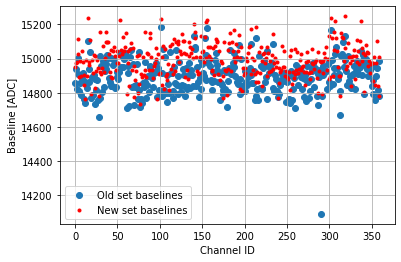

In [16]:
plt.scatter(ids,old_baselines, label="Old set baselines")
plt.scatter(b2["channel_id"],b2["baseline"], marker=".", color="red", label="New set baselines")
plt.grid()
plt.xlabel("Channel ID")
plt.ylabel("Baseline [ADC]")
plt.legend()
plt.show()

## Run 8507

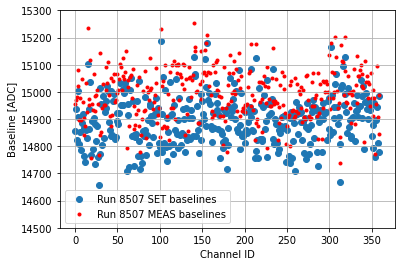

In [8]:
plt.scatter(ids,old_baselines, label="Run 8507 SET baselines")
plt.scatter(b_phy["channel_id"],b_phy["baseline"], marker=".", color="red", label="Run 8507 MEAS baselines")
plt.grid()
plt.xlabel("Channel ID")
plt.ylabel("Baseline [ADC]")
plt.ylim((14500,15300))
plt.legend()
plt.show()

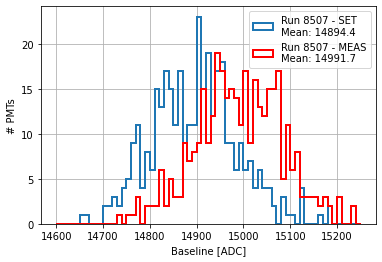

In [11]:
plt.hist( old_baselines, bins=65, range=(14600, 15250), label="Run 8507 - SET\nMean: {:.1f}".format(np.mean(old_baselines)) , histtype='step', lw=2)
plt.hist( b_phy["baseline"], bins=65, range=(14600, 15250), label="Run 8507 - MEAS\nMean: {:.1f}".format(np.mean(b_phy["baseline"])), color="red", histtype='step', lw=2)

plt.grid()
plt.xlabel("Baseline [ADC]")
plt.ylabel("# PMTs")
plt.legend()
plt.show()

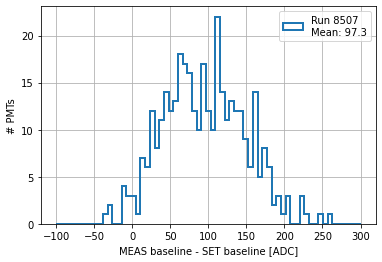

In [15]:
diff = b_phy["baseline"]-old_baselines
plt.hist( diff, bins=65, range=(-100, 300), histtype='step', label="Run 8507\nMean: {:.1f}".format(np.mean(diff)), lw=2.)

plt.grid()
plt.xlabel("MEAS baseline - SET baseline [ADC]")
plt.ylabel("# PMTs")
plt.legend()
plt.show()

# Run 9208

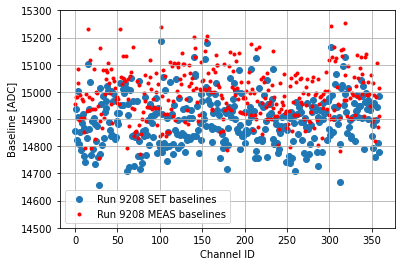

In [17]:
plt.scatter(ids,old_baselines, label="Run 9208 SET baselines")
plt.scatter(b["channel_id"],b["baseline"], marker=".", color="red", label="Run 9208 MEAS baselines")
plt.grid()
plt.xlabel("Channel ID")
plt.ylabel("Baseline [ADC]")
plt.ylim((14500,15300))
plt.legend()
plt.show()

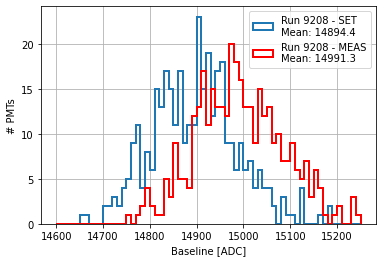

In [53]:
plt.hist( old_baselines, bins=65, range=(14600, 15250), label="Run 9208 - SET\nMean: {:.1f}".format(np.mean(old_baselines)) , histtype='step', lw=2)
plt.hist( b["baseline"], bins=65, range=(14600, 15250), label="Run 9208 - MEAS\nMean: {:.1f}".format(np.mean(b["baseline"])), color="red", histtype='step', lw=2)

plt.grid()
plt.xlabel("Baseline [ADC]")
plt.ylabel("# PMTs")
plt.legend()
plt.show()

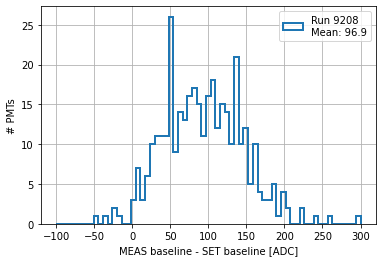

In [56]:
diff = b["baseline"]-old_baselines
plt.hist( diff, bins=65, range=(-100, 300), histtype='step', label="Run 9208\nMean: {:.1f}".format(np.mean(diff)), lw=2.)

plt.grid()
plt.xlabel("MEAS baseline - SET baseline [ADC]")
plt.ylabel("# PMTs")
plt.legend()
plt.show()

In [34]:
# channel ids
map = readSqlitedb()
#print(ids)
chs = get_PMT_id(map,ids)
#print(chs)
#print(b["baseline"])
#print(old_baselines)
new_df = b[['channel_id','baseline']].copy()
new_df['pmt_id'] = get_PMT_id(map,ids)
new_df["set_baseline"] = old_baselines

new_df = new_df[['channel_id', 'pmt_id', 'set_baseline', 'baseline']]
new_df.rename( columns = { 'baseline':"meas_baseline"}, inplace=True)
print(new_df)
new_df.to_csv("run9208_set_measured_baselines.csv", sep=",")

     channel_id  pmt_id  set_baseline  meas_baseline
0             0     356         14855        14954.9
1             1     360         14938        14980.6
2             2     359         14824        14980.5
3             3     357         15003        15085.6
4             4     358         14907        15033.4
..          ...     ...           ...            ...
355         355       9         14898        14980.8
356         356       7         14946        15104.9
357         357       8         14813        14870.1
358         358       6         14984        15015.7
359         359      10         14778        14911.1

[360 rows x 4 columns]


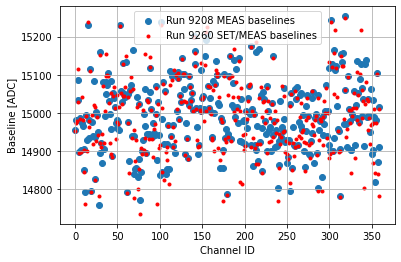

In [16]:
plt.scatter(b["channel_id"],b["baseline"], marker="o", label="Run 9208 MEAS baselines")
plt.scatter(b2["channel_id"],b2["baseline"], marker=".", color="red", label="Run 9260 SET/MEAS baselines")

plt.grid()
plt.xlabel("Channel ID")
plt.ylabel("Baseline [ADC]")
plt.legend()
plt.show()

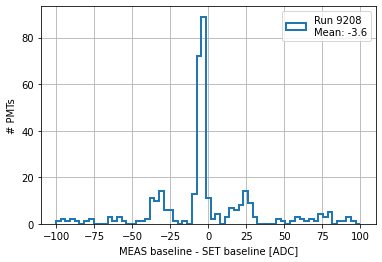

In [18]:
diff = b2["baseline"]-b["baseline"]
plt.hist( diff, bins=65, range=(-100, 100), histtype='step', label="Run 9208\nMean: {:.1f}".format(np.mean(diff)), lw=2.)

plt.grid()
plt.xlabel("MEAS baseline - SET baseline [ADC]")
plt.ylabel("# PMTs")
plt.legend()
plt.show()

[]

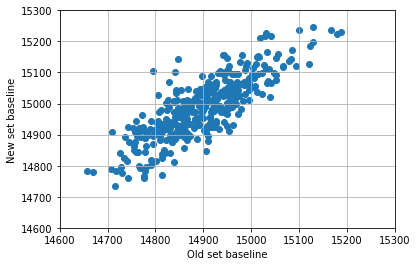

In [40]:
plt.scatter(old_baselines,b2["baseline"])
plt.xlabel("Old set baseline")
plt.ylabel("New set baseline")
plt.ylim((14600,15300))
plt.xlim((14600,15300))
plt.grid()
plt.plot()

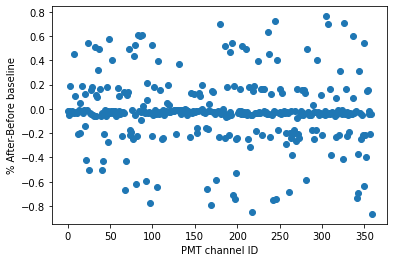

In [7]:
plt.scatter(b["channel_id"].to_numpy(), (b2["baseline"].to_numpy()-b["baseline"].to_numpy())/b["baseline"].to_numpy()*100)
plt.xlabel("PMT channel ID")
plt.ylabel("% After-Before baseline")
plt.show()

# Threshold check

In [6]:
thr = 390
meas_bs = b2["baseline"].to_numpy()
threshold = meas_bs-thr

(array([18., 17., 24., 22., 11.,  7., 26., 18., 20., 17., 20., 21., 12.,
        17.,  4., 15.,  7.,  8.,  4.,  8.,  3.,  1.,  1.,  1.,  3.,  3.,
         3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([14500.        , 14513.33333333, 14526.66666667, 14540.        ,
        14553.33333333, 14566.66666667, 14580.        , 14593.33333333,
        14606.66666667, 14620.        , 14633.33333333, 14646.66666667,
        14660.        , 14673.33333333, 14686.66666667, 14700.        ,
        14713.33333333, 14726.66666667, 14740.        , 14753.33333333,
        14766.66666667, 14780.        , 14793.33333333, 14806.66666667,
        14820.        , 14833.33333333, 14846.66666667, 14860.        ,
        14873.33333333, 14886.66666667, 14900.        , 14913.33333333,
        14926.66666667, 14940.        , 14953.33333333, 14966.66666667,
        14

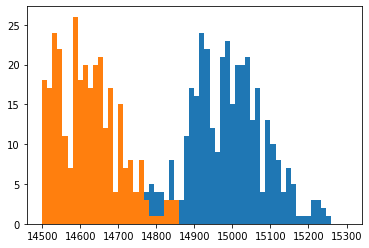

In [10]:
plt.hist(meas_bs, bins=60, range=(14500,15300), histtype='bar', lw=2, label="Baselines")
plt.hist(threshold, bins=60, range=(14500,15300), histtype='bar', lw=2, label="Baselines")